**Create the interpratibility plot**





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
# Obtain the LDA features:

covid_lda_features_tr_path = 'https://github.com/anonymousreposi/LDAVAE/blob/main/Examples/Covid/lda_tfidf_train.csv'
covid_lda_features_tr_path = covid_lda_features_tr_path.replace('github.com', 'raw.githubusercontent.com', 1)
covid_lda_features_tr_path = covid_lda_features_tr_path.replace('/blob/', '/',1)

covid_lda_features_te_path = 'https://github.com/anonymousreposi/LDAVAE/blob/main/Examples/Covid/lda_tfidf_test.csv'
covid_lda_features_te_path = covid_lda_features_te_path.replace('github.com', 'raw.githubusercontent.com', 1)
covid_lda_features_te_path = covid_lda_features_te_path.replace('/blob/', '/',1)

covid_lda_features_tr = pd.read_csv(covid_lda_features_tr_path, index_col=0)
covid_lda_features_te = pd.read_csv(covid_lda_features_te_path, index_col=0)


In [3]:
# Download the labels

labels_tr_path = 'https://github.com/anonymousreposi/LDAVAE/blob/main/Examples/Covid/tr_labels.csv'
labels_tr_path = labels_tr_path.replace('github.com', 'raw.githubusercontent.com', 1)
labels_tr_path = labels_tr_path.replace('/blob/', '/',1)
covid_labels_tr = pd.read_csv(labels_tr_path, index_col=0)

labels_te_path = 'https://github.com/anonymousreposi/LDAVAE/blob/main/Examples/Covid/te_labels.csv'
labels_te_path = labels_te_path.replace('github.com', 'raw.githubusercontent.com', 1)
labels_te_path = labels_te_path.replace('/blob/', '/',1)
covid_labels_te = pd.read_csv(labels_te_path, index_col=0)


In [4]:
# Make the data, separate by class labels

lda_tr_df = pd.concat([covid_lda_features_tr, covid_labels_tr], axis=1)
lda_te_df = pd.concat([covid_lda_features_te, covid_labels_te], axis=1)
lda_df = pd.concat([lda_tr_df, lda_te_df], axis=0, ignore_index=True)
fake_df = lda_df[lda_df['label'] == 1].reset_index()
real_df = lda_df[lda_df['label'] == 0].reset_index()
fake_np = fake_df[fake_df.columns[1:11]].to_numpy()
real_np = real_df[real_df.columns[1:11]].to_numpy()
covid_data = [list(np.mean(real_np, axis=0)), list(np.mean(fake_np, axis=0))]
covid_data

[[0.06460827046661079,
  0.12117197541212629,
  0.16211288069293098,
  0.24086378876781225,
  0.06987775915060074,
  0.08240318524727579,
  0.0762144453758033,
  0.06616708577815032,
  0.06150083822296732,
  0.055248672813635095],
 [0.17769651845637582,
  0.0497186451342282,
  0.10588296979865772,
  0.058755453020134234,
  0.12303439597315435,
  0.07723835989932885,
  0.09361430369127517,
  0.06162091023489934,
  0.10224591023489933,
  0.15040425755033557]]

In [5]:
# Plot function

def radar_factory(num_vars, frame='circle'):
    """
    credit to matplotlib.org
    Class copied from:
    https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


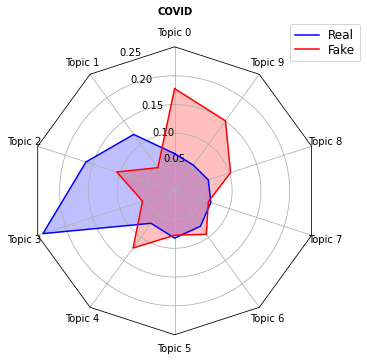

In [6]:
# Plot Categories

categories = ['Topic ' + str(i) for i in range(10)]
data = [categories, covid_data]
varphi = radar_factory(10, frame='polygon')
colors = ['b', 'r']

fig, axs = plt.subplots(figsize=(19, 5), nrows=1, ncols=1, 
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
axs.set_title('COVID', weight='bold', size='medium', position=(0.5, 1.1),
              horizontalalignment='center', verticalalignment='center')
for i in range(2):
  axs.plot(varphi, covid_data[i], color=colors[i])
  axs.fill(varphi, covid_data[i], facecolor=colors[i], alpha=0.25)
  axs.set_varlabels(categories)
labels = ('Real', 'Fake')
legend = axs.legend(labels, loc=(0.9, .95), labelspacing=0.1, fontsize='large')
plt.show()
